In [2]:
!pip install gensim torch torchvision
from __future__ import print_function
import gensim.downloader as api # package to download text corpus
import nltk # text processing
from nltk.corpus import stopwords
import string


In [3]:
# download stopwords
nltk.download('stopwords')

# download textcorpus
data = api.load('text8')

# collect all words to be removed
stop = stopwords.words('english') + list(string.punctuation)

actual_words = []
cleaned_words = []
unique_words = set()

# remove stop words
print('removing stop words from text corpus')
for words in data:
    current_nonstop_words = [w for w in words if w not in stop]
    #print(current_nonstop_words)
    cleaned_words += current_nonstop_words
    actual_words += words

    for ns in current_nonstop_words:
        unique_words.add(ns)

# print statistics
print(len(actual_words), 'words BEFORE cleaning stop words and punctuations')
print(len(cleaned_words), 'words AFTER cleaning stop words and punctuations')
print('vocabulary size: ', len(unique_words))

# 'cleaned_words' and 'unique_words' to create a word2vec model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[==================================================] 100.0% 31.6/31.6MB downloaded
removing stop words from text corpus
17005207 words BEFORE cleaning stop words and punctuations
10890638 words AFTER cleaning stop words and punctuations
vocabulary size:  253702


In [0]:
word2idx = {w: idx for (idx, w) in enumerate(unique_words)}
idx2word = {idx: w for (idx, w) in enumerate(unique_words)}

In [5]:
#word2idx
idx2word

{0: 'banawa',
 1: 'catu',
 2: 'likeable',
 3: 'anerood',
 4: 'stratospheric',
 5: 'blackfeet',
 6: 'subinterval',
 7: 'conuropsis',
 8: 'villone',
 9: 'trapezia',
 10: 'viterelli',
 11: 'ksl',
 12: 'manito',
 13: 'latomus',
 14: 'lindane',
 15: 'bambini',
 16: 'hirshleifer',
 17: 'pinchpenny',
 18: 'echochamber',
 19: 'simscript',
 20: 'finster',
 21: 'baabul',
 22: 'kiljan',
 23: 'eigentransform',
 24: 'sain',
 25: 'eny',
 26: 'adipocyte',
 27: 'thabo',
 28: 'carnations',
 29: 'heimosodat',
 30: 'newvalue',
 31: 'gotmoor',
 32: 'nogah',
 33: 'tutta',
 34: 'thawings',
 35: 'kindle',
 36: 'gatecrasher',
 37: 'meningococcus',
 38: 'polovchak',
 39: 'barenaked',
 40: 'carpi',
 41: 'nayshapur',
 42: 'zuari',
 43: 'daigh',
 44: 'nehring',
 45: 'streptomyces',
 46: 'salutamus',
 47: 'freewoman',
 48: 'qmail',
 49: 'satz',
 50: 'punctuations',
 51: 'pupae',
 52: 'treacher',
 53: 'kanji',
 54: 'lemarchand',
 55: 'boingo',
 56: 'freewill',
 57: 'gorlag',
 58: 'polassar',
 59: 'naubakht',
 60: '

In [0]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

BoW


In [0]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in data:
    sentence = [w for w in words if w not in stop]
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # convert to numpy array

In [0]:
def get_input_layer(word_idx):
    x = torch.zeros(len(unique_words)).cuda().float()
    x[word_idx] = 1.0
    return x

In [13]:
embedding_dims = 100
W1 = Variable(torch.randn(embedding_dims, len(unique_words)).cuda().float(), requires_grad=True)
W2 = Variable(torch.randn(len(unique_words), embedding_dims).cuda().float(), requires_grad=True)
num_epochs = 11
learning_rate = 0.1
losses = []
for epo in range(num_epochs):
    loss_val = 0
    for data1, target in idx_pairs[0:1000]:
        x = Variable(get_input_layer(data1)).cuda().float()
        y_true = Variable(torch.from_numpy(np.array([target])).cuda().long())
        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data[0]
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 1 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
    losses.append((loss_val/len(idx_pairs)).cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss at epo 0: 0.0015857042744755745
Loss at epo 1: 0.0007685731397941709
Loss at epo 2: 0.0005798473721370101
Loss at epo 3: 0.0005404570256359875
Loss at epo 4: 0.0004888349794782698
Loss at epo 5: 0.00044467524276115
Loss at epo 6: 0.00040809865458868444
Loss at epo 7: 0.00037648933357559144
Loss at epo 8: 0.000349535170244053
Loss at epo 9: 0.00032584264408797026
Loss at epo 10: 0.000305217137793079


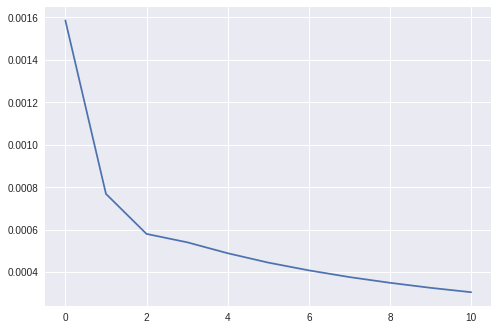

In [15]:
import matplotlib.pyplot as plt
xaxis = [0,1,2,3,4,5,6,7,8,9,10]
plt.plot(xaxis,losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss at epo 0: 0.0023260393645614386
Loss at epo 1: 0.0012543221237137914
Loss at epo 2: 0.0011555287055671215
Loss at epo 3: 0.001024138182401657
Loss at epo 4: 0.0009156184387393296
Loss at epo 5: 0.000819816195871681
Loss at epo 6: 0.0007379744783975184
Loss at epo 7: 0.0006719763623550534
Loss at epo 8: 0.0006137195159681141
Loss at epo 9: 0.000561993510928005
Loss at epo 10: 0.0005187959759496152


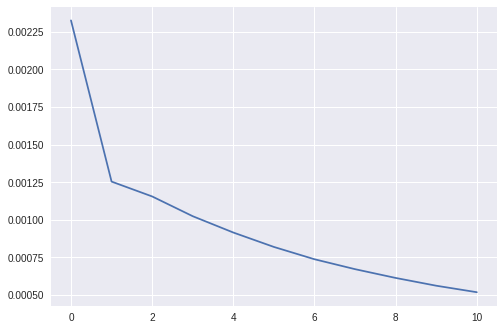

In [16]:
embedding_dims = 200
W1 = Variable(torch.randn(embedding_dims, len(unique_words)).cuda().float(), requires_grad=True)
W2 = Variable(torch.randn(len(unique_words), embedding_dims).cuda().float(), requires_grad=True)
num_epochs = 11
learning_rate = 0.1
losses = []
for epo in range(num_epochs):
    loss_val = 0
    for data1, target in idx_pairs[0:1000]:
        x = Variable(get_input_layer(data1)).cuda().float()
        y_true = Variable(torch.from_numpy(np.array([target])).cuda().long())
        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data[0]
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 1 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
    losses.append((loss_val/len(idx_pairs)).cpu().numpy())
xaxis = [0,1,2,3,4,5,6,7,8,9,10]
plt.plot(xaxis,losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss at epo 0: 0.0011325713712722063
Loss at epo 1: 0.0006176710012368858
Loss at epo 2: 0.00041226137545891106
Loss at epo 3: 0.0003309681487735361
Loss at epo 4: 0.00030145543860271573
Loss at epo 5: 0.00027796789072453976
Loss at epo 6: 0.0002585917245596647
Loss at epo 7: 0.00024240926722995937
Loss at epo 8: 0.00022880799951963127
Loss at epo 9: 0.00021718547213822603
Loss at epo 10: 0.0002071931812679395


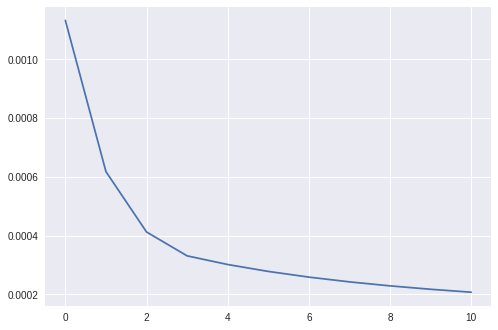

In [17]:
embedding_dims = 50
W1 = Variable(torch.randn(embedding_dims, len(unique_words)).cuda().float(), requires_grad=True)
W2 = Variable(torch.randn(len(unique_words), embedding_dims).cuda().float(), requires_grad=True)
num_epochs = 11
learning_rate = 0.1
losses = []
for epo in range(num_epochs):
    loss_val = 0
    for data1, target in idx_pairs[0:1000]:
        x = Variable(get_input_layer(data1)).cuda().float()
        y_true = Variable(torch.from_numpy(np.array([target])).cuda().long())
        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data[0]
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 1 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
    losses.append((loss_val/len(idx_pairs)).cpu().numpy())
xaxis = [0,1,2,3,4,5,6,7,8,9,10]
plt.plot(xaxis,losses)

CBOW

In [0]:
def get_index_of_max(input):
  index = 0
  for i in range(1, len(input)):
    if(input[i] > input[index]):
      index = i 
  return index
window_size = 2  # 2 words to the left, 2 to the right
embedding_dims = 100

trainData = []
for sentence in data:
    sentence = [w for w in words if w not in stop]
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(window_size,len(indices)-window_size):
      i = center_word_pos
      context = [indices[i - 2], indices[i - 1],indices[i + 1], indices[i + 2]]
      target = indices[i]
      trainData.append((context, target))

In [0]:
import torch.nn as nn

In [0]:
vocab_size=len(unique_words)
class CBOW(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(CBOW, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(embedding_dim, 128)
    self.activation_function1 = nn.ReLU()
    self.linear2 = nn.Linear(128, vocab_size)
    self.activation_function2 = nn.LogSoftmax(dim = -1)
  def forward(self, inputs):
    embeds = sum(self.embeddings(inputs)).view(1,-1)
    out = self.linear1(embeds)
    out = self.activation_function1(out)
    out = self.linear2(out)
    out = self.activation_function2(out)
    return out
  def get_word_emdedding(self, word):
    word = torch.LongTensor([word2idx[word]])
    return self.embeddings(word).view(1,-1)

model = CBOW(vocab_size, embedding_dims)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


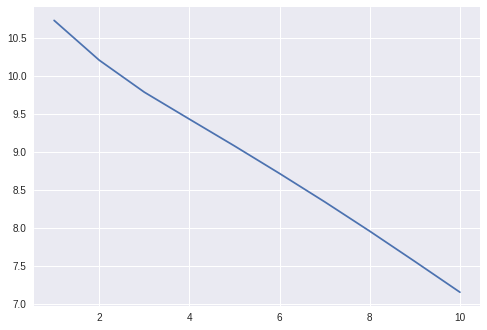

In [24]:
losses=[]
for epoch in range(10):
  total_loss = 0
  for i in range(1000):
    context_vector = np.asarray(trainData[i][0])
    context_vector=torch.from_numpy(context_vector)
    target = trainData[i][1]
    target=torch.from_numpy(np.asarray([target]))
    model.zero_grad()
    log_probs = model(context_vector)
    loss = loss_function(log_probs, target)
    loss.backward()
    optimizer.step()
    total_loss += loss.data
    if(i%100==0):
      print(i)
  losses.append(total_loss.cpu().numpy()/1000)
xaxis = [1,2,3,4,5,6,7,8,9,10]
plt.plot(xaxis,losses)